In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from matplotlib.pyplot import figure
from matplotlib.pyplot import title
# from .preprocessing import *
from imblearn.under_sampling import OneSidedSelection
from sklearn.preprocessing import OneHotEncoder


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from pprint import pprint

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import optuna

import gc
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load your data
train_data = pd.read_csv("./preprocessed-data/train.csv")
test_data = pd.read_csv("./preprocessed-data/test.csv")

### Split Data

In [4]:
# Splitting data into training and validation sets
X = train_data.drop("readmission_id", axis=1)
y = train_data["readmission_id"]

In [5]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Pre-Processing of Numerical & Categorical Columns

In [6]:
# Identifying categorical and numerical columns
categorical_cols = x_train.select_dtypes(include=["object"]).columns
numerical_cols = x_train.select_dtypes(include=["int64", "float64"]).columns

In [7]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Preprocessing for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [8]:
# Apply preprocessing
print("Before preprocessing: ")
print("Training set: ", x_train.shape)
print("Validation set: ", x_val.shape)
print()
x_train = preprocessor.fit_transform(x_train)
x_val = preprocessor.transform(x_val)
print("After preprocessing: ")
print("Training set: ", x_train.shape)
print("Validation set: ", x_val.shape)

Before preprocessing: 
Training set:  (56988, 34)
Validation set:  (14248, 34)

After preprocessing: 
Training set:  (56988, 72)
Validation set:  (14248, 72)


### Finding most important features

In [9]:
x_train_df = pd.DataFrame(x_train)

In [10]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train_df, y_train)

RandomForestClassifier(random_state=42)

Text(0.5, 1.0, 'Feature Importance')

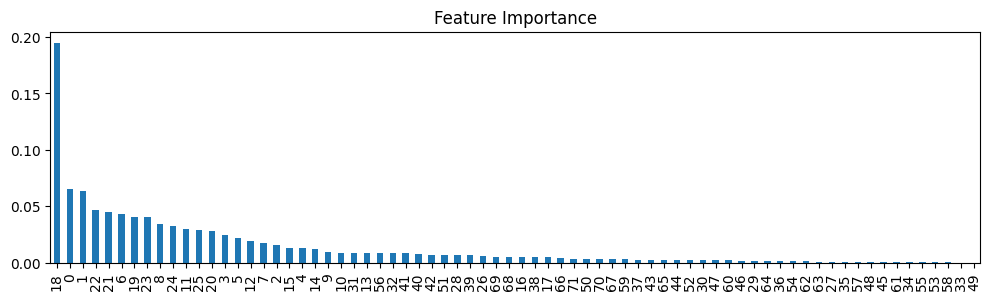

In [11]:
figure(figsize=(12, 3))
features = x_train_df.columns.values.tolist()
importance = rfc.feature_importances_.tolist()
feature_series = pd.Series(data=importance, index=features).sort_values(ascending=False)

feature_series.plot.bar()
title("Feature Importance")

In [12]:
feature_names = feature_series[:24].index.tolist()
feature_names

[18,
 0,
 1,
 22,
 21,
 6,
 19,
 23,
 8,
 24,
 11,
 25,
 20,
 3,
 5,
 12,
 7,
 2,
 15,
 4,
 14,
 9,
 10,
 31]

In [13]:
print("Before dropping less important columns: ")
print("Training set: ", x_train.shape)
print("Validation set: ", x_val.shape)

x_train = x_train_df[feature_names]
x_val = x_val[:, feature_names]

print("After dropping less important columns:")
print("Training set: ", x_train.shape)
print("Validation set: ", x_val.shape)

Before dropping less important columns: 
Training set:  (56988, 72)
Validation set:  (14248, 72)
After dropping less important columns:
Training set:  (56988, 24)
Validation set:  (14248, 24)


## NN

In [14]:
y_val

61454    0
63374    2
29569    0
31619    2
47114    0
        ..
30444    2
67920    2
7823     1
28604    1
63955    0
Name: readmission_id, Length: 14248, dtype: int64

In [15]:
class Data(Dataset):
    def __init__(self, x, y):
        self.x=torch.from_numpy(x)
        self.y=torch.from_numpy(y)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [16]:
train_dataset = Data(x_train.to_numpy().astype('float64'), y_train.to_numpy())
test_dataset = Data(x_val.astype('float64'), y_val.to_numpy())

In [17]:
train_dataloader = DataLoader(train_dataset,batch_size=64)
test_dataloader = DataLoader(test_dataset,batch_size=64)

In [18]:
class ANN(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim_1: int,
        hidden_dim_2: int,
        n_classes:int = 3,
        dropout:float = 0.2
    ):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hidden_dim_1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_1),
            nn.Dropout(dropout),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(in_features=hidden_dim_1, out_features=hidden_dim_2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim_2),
            nn.Dropout(dropout),
        )
        self.output_layer = nn.Linear(in_features=hidden_dim_2, out_features=n_classes)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x.to(dtype=torch.float)
        # x=x.astype('float')
        x = self.layer1(x)
        # x=x.astype('float')
        x = self.layer2(x)
        # x=x.astype('float')
        x = self.output_layer(x)
        return x

In [19]:
model = ANN(24,21,20).to(device)

In [20]:
n_epochs = 25
lr = 1e-4
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

In [21]:
import matplotlib.pyplot as plt
losses = []
accuracies = []
f1s = []
def train_epoch(model, dataloader, optimiser, verbose=True):
    model.train()
    loss_sum = 0
    for batch in tqdm(dataloader, disable=not verbose):
        x, y = batch[0].to(device), batch[1].to(device)
        output = model(x)
        output = nn.Softmax(dim=-1)(output)
        loss = loss_fn(output, y)
        loss_sum += loss.item()  

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    loss_sum /= len(dataloader)
    losses.append(loss_sum)
        
        
def validate(model):
    model.eval()
    output = model(torch.from_numpy(x_val).to(device))
    output = nn.Softmax(dim=-1)(output)
    preds = torch.argmax(output,dim=-1)
            
        
    acc = accuracy_score(y_true=y_val.to_numpy(), y_pred=preds.cpu())
    accuracies.append(acc)
    f1 = f1_score(y_true=y_val.to_numpy(), y_pred=preds.cpu(), average='macro')
    f1s.append(f1)
    
    return acc, f1

In [22]:
def train_model(model, train_dataloader, test_dataloader, optimiser, verbose=True):
    for epoch in range(1, n_epochs+1):
        start_time = time.time()
        
        if verbose: print(f"========= EPOCH {epoch} STARTED =========")
        train_epoch(model=model, dataloader=train_dataloader, optimiser=optimiser, verbose=verbose)
        
        if verbose: print(f"========= TEST EVALUATION STARTED =========")
        test_val_op = validate(model=model)
        
        if verbose: print(f"END OF {epoch} EPOCH")
        if verbose: print(f"| Time taken: {time.time() - start_time: 7.3f} |")
        if verbose: print(f"| Test acc: {test_val_op[0]: 1.5f}  | Test f1: {test_val_op[1]: 1.5f}  |")

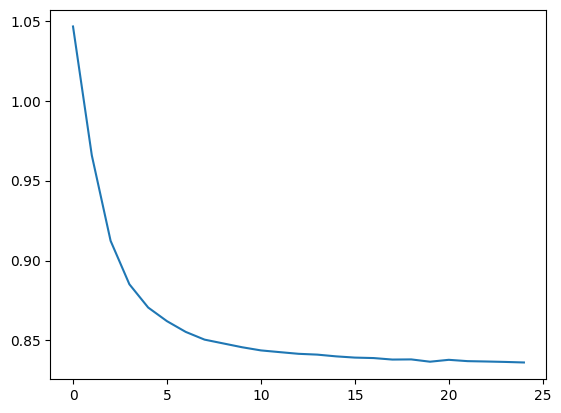

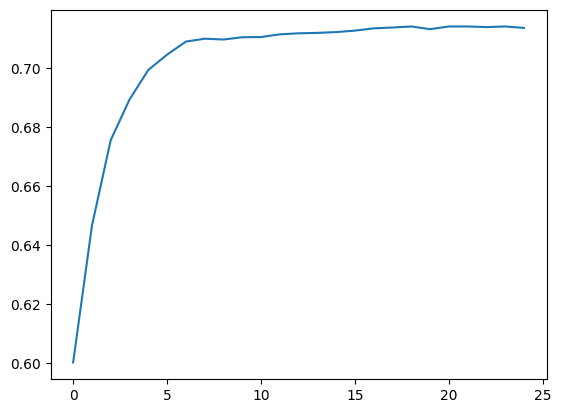

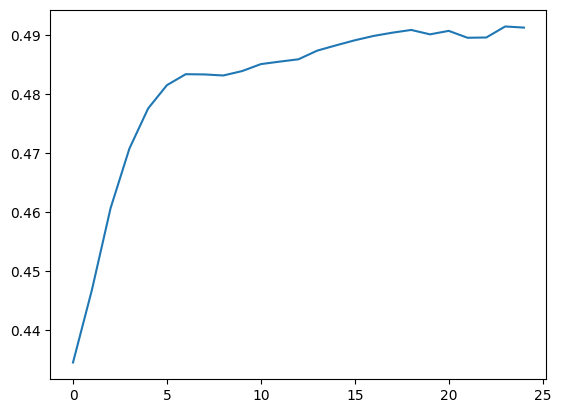

In [23]:
train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimiser=optimiser,
    verbose=False
)
sns.lineplot(x=range(len(losses)), y=losses)
plt.show()
sns.lineplot(x=range(len(accuracies)), y=accuracies)
plt.show()
sns.lineplot(x=range(len(f1s)), y=f1s)
plt.show()

In [24]:
test_data

,enc_id,patient_id,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,number_of_up,number_of_down,new_patient_id,num_medications|time_in_hospital,num_medications|num_procedures,time_in_hospital|num_lab_procedures,num_medications|num_lab_procedures,num_medications|number_diagnoses,number_diagnoses|time_in_hospital,service_utilization
0,86305392,23846112,Caucasian,Male,[40-50),5,5,17,12,MC,...,0,0,7,348,87,300,725,261,108,4
1,394919696,90620001,Caucasian,Male,[80-90),2,3,7,3,MC,...,0,1,1,72,0,177,1416,216,27,1
2,164917446,25342173,AfricanAmerican,Female,[60-70),3,1,1,8,HM,...,0,1,3,184,0,376,1081,207,72,0
3,178319040,23481783,AfricanAmerican,Female,[70-80),1,3,7,10,Other,...,1,0,12,380,228,460,1748,342,90,9
4,253585416,86500791,Caucasian,Male,[70-80),1,6,7,5,HM,...,0,0,4,80,16,320,1024,144,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30525,169542282,23401863,AfricanAmerican,Female,[70-80),1,6,7,2,MC,...,0,0,3,38,0,88,836,95,10,2
30526,37906254,12267054,Caucasian,Male,[50-60),3,18,4,2,Other,...,0,0,1,20,30,38,190,80,16,0
30527,242799822,98403552,Caucasian,Female,[70-80),1,3,7,5,MC,...,1,0,4,120,72,365,1752,216,45,1
30528,204193212,87646410,Caucasian,Female,[80-90),1,3,7,2,MC,...,0,0,4,26,0,126,819,117,18,1


In [25]:
X_test = preprocessor.transform(test_data)
X_test_df = pd.DataFrame(X_test)
x = X_test_df[feature_names]

In [26]:
x.shape

(30530, 24)

In [27]:
x.head()

,18,0,1,22,21,6,19,23,8,24,...,5,12,7,2,15,4,14,9,10,31
0,1.937071,-0.766208,-0.782838,-0.014830,0.461962,-0.920799,2.962042,1.823948,1.592330,2.817821,...,2.545438,0.822113,0.966230,2.072167,0.115235,2.778822,0.197470,-0.290078,-0.224091,0.0
1,-0.514565,2.234808,0.944860,1.157631,-0.157606,0.808546,-0.109477,1.229489,0.978880,-0.261424,...,-0.468046,0.822113,-0.787646,-0.012805,-0.996497,0.311194,0.197470,-0.290078,0.907444,0.0
2,0.302647,-0.001771,-0.744130,0.589217,0.844784,0.198189,1.136936,1.110597,0.856190,1.449268,...,1.206111,0.822113,-0.787646,0.682185,-0.996497,-1.169382,0.197470,-0.290078,-0.224091,1.0
3,3.980100,0.128548,-0.792265,1.720955,1.267904,0.147326,3.318160,2.893976,2.696542,2.133544,...,1.875775,0.822113,2.720106,-0.707796,0.115235,0.311194,-0.887513,-0.290078,2.038980,1.0
4,0.711253,0.860450,0.838281,0.492501,0.562705,1.062861,-0.020448,0.278353,-0.002642,0.422853,...,0.201617,0.822113,-0.203021,-0.707796,-0.996497,0.311194,1.282454,-0.290078,-0.224091,0.0


In [28]:
# makes a submission file; input -> transfromed test data
def submit(df, model=model):
    output = model(torch.from_numpy(df.to_numpy()).to(device))
    output = nn.Softmax(dim=-1)(output)
    preds = torch.argmax(output,dim=-1)

    submission = pd.DataFrame({"enc_id":test_data["enc_id"], "readmission_id": preds.cpu().numpy()})
    submission.to_csv("./submission.csv", index=False)

# prints the predictions and their counts
def print_pred_stats(df, model=model):
    output = model(torch.from_numpy(df.to_numpy()).to(device))
    output = nn.Softmax(dim=-1)(output)
    preds = torch.argmax(output,dim=-1)
    print(preds.cpu(), np.unique(preds.cpu(), return_counts=True))

def get_train_stats(df, model=model):
    output = model(torch.from_numpy(df.to_numpy()).to(device))
    output = nn.Softmax(dim=-1)(output)
    preds = torch.argmax(output,dim=-1)
    print(accuracy_score(y_true=y_val, y_pred=preds.cpu()))

In [31]:
print_pred_stats(x)
submit(x) 

tensor([1, 2, 1,  ..., 1, 1, 1]) (array([0, 1, 2], dtype=int64), array([   96, 10407, 20027], dtype=int64))


### Hyperparameter Tuning

In [70]:
def task(trial):
    in_dim = X.shape[1]
    num_layers = trial.suggest_int('num_layers', 1, 3)  # Number of layers to optimize
    layer_units = [in_dim] + [trial.suggest_int(f'layer_units_{i}', in_dim // 2**(i+1), in_dim // 2**i) for i in range(num_layers)]
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    n_epochs = 25
    train_model(
        model=model,            # global variable model used
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,    # global optimiser used
        verbose=False
    )

    acc, _ = validate(model=model)
    return acc

In [71]:
study = optuna.create_study(direction='maximize')
study.optimize(task, n_trials=20)

[I 2023-12-17 13:57:20,535] A new study created in memory with name: no-name-1993866f-e3bb-43d3-9633-67992ffb371a
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 420.66it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.134 |
| Test acc:  0.72179  | Test f1:  0.51447  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 410.53it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.185 |
| Test acc:  0.72193  | Test f1:  0.51244  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.22it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.237 |
| Test acc:  0.72333  | Test f1:  0.51591  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.94it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.187 |
| Test acc:  0.72101  | Test f1:  0.51321  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 405.98it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.201 |
| Test acc:  0.72143  | Test f1:  0.51155  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 416.17it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.159 |
| Test acc:  0.72094  | Test f1:  0.51173  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.25it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.226 |
| Test acc:  0.72193  | Test f1:  0.51494  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.75it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.218 |
| Test acc:  0.72101  | Test f1:  0.51464  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 414.11it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.167 |
| Test acc:  0.72108  | Test f1:  0.51339  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 403.47it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.220 |
| Test acc:  0.72165  | Test f1:  0.51263  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.24it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.176 |
| Test acc:  0.72066  | Test f1:  0.51324  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 395.69it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.269 |
| Test acc:  0.72122  | Test f1:  0.51364  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.20it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.205 |
| Test acc:  0.72143  | Test f1:  0.51484  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.55it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.233 |
| Test acc:  0.72115  | Test f1:  0.51619  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.03it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.181 |
| Test acc:  0.72094  | Test f1:  0.51464  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.17it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.220 |
| Test acc:  0.72080  | Test f1:  0.51529  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.94it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.187 |
| Test acc:  0.72059  | Test f1:  0.51416  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 429.75it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.101 |
| Test acc:  0.72066  | Test f1:  0.51236  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.78it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.199 |
| Test acc:  0.72052  | Test f1:  0.51266  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.96it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.187 |
| Test acc:  0.72136  | Test f1:  0.51522  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.22it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.202 |
| Test acc:  0.72179  | Test f1:  0.51521  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 410.40it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.187 |
| Test acc:  0.72150  | Test f1:  0.51521  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.58it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.216 |
| Test acc:  0.72115  | Test f1:  0.51343  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.68it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.173 |
| Test acc:  0.72038  | Test f1:  0.51031  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 408.27it/s]
[I 2023-12-17 13:58:15,418] Trial 0 finished with value: 0.7212240314430095 and parameters: {'num_layers': 1, 'layer_units_0': 23, 'dropout': 0.3217362902301998, 'lr': 0.005751888876747987}. Best is trial 0 with value: 0.7212240314430095.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.200 |
| Test acc:  0.72122  | Test f1:  0.51340  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 403.24it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.222 |
| Test acc:  0.72094  | Test f1:  0.51401  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 405.66it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.206 |
| Test acc:  0.72122  | Test f1:  0.51294  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.73it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.188 |
| Test acc:  0.72101  | Test f1:  0.51404  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.02it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.206 |
| Test acc:  0.72186  | Test f1:  0.51365  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.40it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.229 |
| Test acc:  0.72172  | Test f1:  0.51415  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 405.98it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.210 |
| Test acc:  0.72200  | Test f1:  0.51502  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.07it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.242 |
| Test acc:  0.72066  | Test f1:  0.51219  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.90it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.235 |
| Test acc:  0.72066  | Test f1:  0.51600  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.37it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.069 |
| Test acc:  0.72052  | Test f1:  0.51215  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.12it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.205 |
| Test acc:  0.72143  | Test f1:  0.51529  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.97it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.200 |
| Test acc:  0.72122  | Test f1:  0.51199  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 408.96it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.186 |
| Test acc:  0.72101  | Test f1:  0.51242  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.21it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.210 |
| Test acc:  0.72059  | Test f1:  0.51364  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.38it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.248 |
| Test acc:  0.72101  | Test f1:  0.51391  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.19it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.223 |
| Test acc:  0.72087  | Test f1:  0.51448  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.56it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.250 |
| Test acc:  0.72122  | Test f1:  0.51385  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.32it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.173 |
| Test acc:  0.72108  | Test f1:  0.51408  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.46it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.236 |
| Test acc:  0.72129  | Test f1:  0.51232  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 405.87it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.206 |
| Test acc:  0.72087  | Test f1:  0.51304  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.26it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.225 |
| Test acc:  0.72136  | Test f1:  0.51286  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.04it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.236 |
| Test acc:  0.72052  | Test f1:  0.51557  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 403.17it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.221 |
| Test acc:  0.71996  | Test f1:  0.51363  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 405.58it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.210 |
| Test acc:  0.72115  | Test f1:  0.51378  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.56it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.034 |
| Test acc:  0.71947  | Test f1:  0.51440  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.44it/s]
[I 2023-12-17 13:59:10,380] Trial 1 finished with value: 0.7203818079730488 and parameters: {'num_layers': 1, 'layer_units_0': 32, 'dropout': 0.20493650775111336, 'lr': 0.00637711476741722}. Best is trial 0 with value: 0.7212240314430095.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.077 |
| Test acc:  0.72038  | Test f1:  0.51326  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.66it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.071 |
| Test acc:  0.72080  | Test f1:  0.51206  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.48it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.071 |
| Test acc:  0.71982  | Test f1:  0.51427  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 386.52it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.315 |
| Test acc:  0.72087  | Test f1:  0.51289  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 390.19it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.294 |
| Test acc:  0.72150  | Test f1:  0.51250  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 413.46it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.172 |
| Test acc:  0.72214  | Test f1:  0.51353  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 403.61it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.220 |
| Test acc:  0.72045  | Test f1:  0.51345  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.88it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.232 |
| Test acc:  0.72179  | Test f1:  0.51464  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 398.63it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.250 |
| Test acc:  0.72172  | Test f1:  0.51408  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.80it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.235 |
| Test acc:  0.72186  | Test f1:  0.51588  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 403.73it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.218 |
| Test acc:  0.72214  | Test f1:  0.51503  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.57it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.214 |
| Test acc:  0.72059  | Test f1:  0.51114  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 398.58it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.242 |
| Test acc:  0.72235  | Test f1:  0.51608  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.49it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.221 |
| Test acc:  0.72165  | Test f1:  0.51426  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.74it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.210 |
| Test acc:  0.72172  | Test f1:  0.51453  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.79it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.085 |
| Test acc:  0.72242  | Test f1:  0.51533  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 428.23it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.088 |
| Test acc:  0.72122  | Test f1:  0.51262  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.38it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.249 |
| Test acc:  0.72101  | Test f1:  0.51120  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.23it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.223 |
| Test acc:  0.72066  | Test f1:  0.51124  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.99it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.230 |
| Test acc:  0.72186  | Test f1:  0.51295  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.05it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.208 |
| Test acc:  0.72115  | Test f1:  0.51419  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 405.94it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.210 |
| Test acc:  0.72094  | Test f1:  0.51309  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.08it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.227 |
| Test acc:  0.72094  | Test f1:  0.51035  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.11it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.034 |
| Test acc:  0.72136  | Test f1:  0.51379  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.48it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.055 |
| Test acc:  0.72157  | Test f1:  0.51449  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 424.85it/s]
[I 2023-12-17 14:00:05,065] Trial 2 finished with value: 0.7214345873104997 and parameters: {'num_layers': 1, 'layer_units_0': 23, 'dropout': 0.27806962524879897, 'lr': 0.005885849033224942}. Best is trial 2 with value: 0.7214345873104997.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.107 |
| Test acc:  0.72143  | Test f1:  0.51439  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.98it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.080 |
| Test acc:  0.72087  | Test f1:  0.51515  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.02it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.062 |
| Test acc:  0.72179  | Test f1:  0.51285  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.58it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.054 |
| Test acc:  0.72150  | Test f1:  0.51364  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.68it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.064 |
| Test acc:  0.72073  | Test f1:  0.51108  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.37it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.214 |
| Test acc:  0.72136  | Test f1:  0.51117  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 408.83it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.190 |
| Test acc:  0.72094  | Test f1:  0.51211  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.62it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.227 |
| Test acc:  0.72073  | Test f1:  0.51264  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 408.51it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.188 |
| Test acc:  0.72087  | Test f1:  0.51337  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 393.55it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.277 |
| Test acc:  0.72024  | Test f1:  0.51379  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 389.72it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.306 |
| Test acc:  0.72094  | Test f1:  0.51485  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 392.39it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.284 |
| Test acc:  0.72094  | Test f1:  0.51027  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 391.16it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.292 |
| Test acc:  0.72045  | Test f1:  0.51203  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.60it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.049 |
| Test acc:  0.72024  | Test f1:  0.51026  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.15it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.232 |
| Test acc:  0.72193  | Test f1:  0.51344  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.22it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.205 |
| Test acc:  0.72115  | Test f1:  0.51021  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.60it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.243 |
| Test acc:  0.72108  | Test f1:  0.51110  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.54it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.200 |
| Test acc:  0.72073  | Test f1:  0.51408  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.05it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.208 |
| Test acc:  0.72214  | Test f1:  0.51465  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.09it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.239 |
| Test acc:  0.72235  | Test f1:  0.51383  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.33it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.175 |
| Test acc:  0.72186  | Test f1:  0.51143  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.07it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.186 |
| Test acc:  0.72291  | Test f1:  0.51557  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 405.28it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.209 |
| Test acc:  0.72045  | Test f1:  0.51393  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.29it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.203 |
| Test acc:  0.72143  | Test f1:  0.51335  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.05it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.060 |
| Test acc:  0.72080  | Test f1:  0.51170  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 430.63it/s]
[I 2023-12-17 14:00:59,613] Trial 3 finished with value: 0.7219258843346434 and parameters: {'num_layers': 1, 'layer_units_0': 21, 'dropout': 0.3920997163518337, 'lr': 0.007618416528710563}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.085 |
| Test acc:  0.72193  | Test f1:  0.51401  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.30it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.233 |
| Test acc:  0.72087  | Test f1:  0.51390  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 398.70it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.245 |
| Test acc:  0.72214  | Test f1:  0.51569  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.26it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.042 |
| Test acc:  0.72157  | Test f1:  0.51640  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 422.21it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.124 |
| Test acc:  0.72108  | Test f1:  0.51420  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 420.75it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.133 |
| Test acc:  0.72094  | Test f1:  0.51075  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.49it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.200 |
| Test acc:  0.72207  | Test f1:  0.51668  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.65it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.062 |
| Test acc:  0.72221  | Test f1:  0.51507  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 440.14it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.047 |
| Test acc:  0.72228  | Test f1:  0.51608  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.22it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.182 |
| Test acc:  0.72221  | Test f1:  0.51084  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.29it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.066 |
| Test acc:  0.72052  | Test f1:  0.51176  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 428.40it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.095 |
| Test acc:  0.72200  | Test f1:  0.51338  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.25it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.057 |
| Test acc:  0.72256  | Test f1:  0.51321  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 442.45it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.025 |
| Test acc:  0.72179  | Test f1:  0.51363  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.50it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.216 |
| Test acc:  0.72150  | Test f1:  0.51396  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.35it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.181 |
| Test acc:  0.72228  | Test f1:  0.51546  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.79it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.188 |
| Test acc:  0.72172  | Test f1:  0.51046  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.24it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.040 |
| Test acc:  0.72136  | Test f1:  0.51065  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.69it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.064 |
| Test acc:  0.72101  | Test f1:  0.51104  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.12it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.054 |
| Test acc:  0.72270  | Test f1:  0.51426  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.36it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.072 |
| Test acc:  0.72172  | Test f1:  0.51243  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.61it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.228 |
| Test acc:  0.72066  | Test f1:  0.51214  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 408.49it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.193 |
| Test acc:  0.72143  | Test f1:  0.51476  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.17it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.074 |
| Test acc:  0.72122  | Test f1:  0.51275  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.75it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.075 |
| Test acc:  0.72179  | Test f1:  0.51515  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.94it/s]
[I 2023-12-17 14:01:52,728] Trial 4 finished with value: 0.7215047725996631 and parameters: {'num_layers': 1, 'layer_units_0': 24, 'dropout': 0.22140475521662714, 'lr': 0.009063695155801127}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.214 |
| Test acc:  0.72150  | Test f1:  0.51417  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.46it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.064 |
| Test acc:  0.72172  | Test f1:  0.51062  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.48it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.221 |
| Test acc:  0.72270  | Test f1:  0.51698  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.04it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.085 |
| Test acc:  0.72150  | Test f1:  0.51327  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 434.90it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.064 |
| Test acc:  0.72249  | Test f1:  0.51354  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 396.45it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.261 |
| Test acc:  0.72256  | Test f1:  0.51471  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.23it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.072 |
| Test acc:  0.72270  | Test f1:  0.51398  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.98it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.067 |
| Test acc:  0.72157  | Test f1:  0.51248  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.94it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.226 |
| Test acc:  0.72270  | Test f1:  0.51432  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 428.65it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.095 |
| Test acc:  0.72256  | Test f1:  0.51260  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 415.01it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.154 |
| Test acc:  0.72115  | Test f1:  0.51100  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.04it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.217 |
| Test acc:  0.72263  | Test f1:  0.51375  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.90it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.238 |
| Test acc:  0.72157  | Test f1:  0.51032  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 414.90it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.160 |
| Test acc:  0.72087  | Test f1:  0.50929  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 417.56it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.146 |
| Test acc:  0.72157  | Test f1:  0.51181  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.06it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.041 |
| Test acc:  0.72038  | Test f1:  0.51070  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.36it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.078 |
| Test acc:  0.72059  | Test f1:  0.51285  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.00it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.078 |
| Test acc:  0.72094  | Test f1:  0.51129  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.33it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.056 |
| Test acc:  0.72031  | Test f1:  0.51022  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.60it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.232 |
| Test acc:  0.72129  | Test f1:  0.51538  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 442.39it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.024 |
| Test acc:  0.72108  | Test f1:  0.51548  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 419.56it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.139 |
| Test acc:  0.71968  | Test f1:  0.51229  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 403.83it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.213 |
| Test acc:  0.72122  | Test f1:  0.51342  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.88it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.078 |
| Test acc:  0.72108  | Test f1:  0.51494  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.91it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.062 |
| Test acc:  0.72087  | Test f1:  0.51626  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 442.41it/s]
[I 2023-12-17 14:02:45,829] Trial 5 finished with value: 0.7210836608646828 and parameters: {'num_layers': 1, 'layer_units_0': 33, 'dropout': 0.4210729747489148, 'lr': 1.5786095668722928e-05}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.030 |
| Test acc:  0.72108  | Test f1:  0.51494  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 395.47it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.267 |
| Test acc:  0.72087  | Test f1:  0.51352  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.04it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.056 |
| Test acc:  0.72129  | Test f1:  0.51367  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.24it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.179 |
| Test acc:  0.72235  | Test f1:  0.51684  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.41it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.215 |
| Test acc:  0.72080  | Test f1:  0.51443  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.13it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.210 |
| Test acc:  0.72172  | Test f1:  0.51336  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.56it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.054 |
| Test acc:  0.72101  | Test f1:  0.51615  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.02it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.062 |
| Test acc:  0.72157  | Test f1:  0.51395  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.27it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.228 |
| Test acc:  0.72052  | Test f1:  0.51592  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 445.64it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.025 |
| Test acc:  0.71940  | Test f1:  0.51179  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 415.03it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.159 |
| Test acc:  0.72038  | Test f1:  0.51385  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.92it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.184 |
| Test acc:  0.72080  | Test f1:  0.51533  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 388.58it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.310 |
| Test acc:  0.72143  | Test f1:  0.51430  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.33it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.215 |
| Test acc:  0.72073  | Test f1:  0.51394  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 423.06it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.124 |
| Test acc:  0.72108  | Test f1:  0.51372  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.25it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.061 |
| Test acc:  0.71975  | Test f1:  0.51188  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 440.66it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.027 |
| Test acc:  0.71968  | Test f1:  0.51230  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.06it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.059 |
| Test acc:  0.72003  | Test f1:  0.51334  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 441.75it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.030 |
| Test acc:  0.72094  | Test f1:  0.51308  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 430.63it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.081 |
| Test acc:  0.72024  | Test f1:  0.51340  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.48it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.034 |
| Test acc:  0.72115  | Test f1:  0.51433  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.92it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.050 |
| Test acc:  0.72157  | Test f1:  0.51362  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 426.94it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.103 |
| Test acc:  0.72094  | Test f1:  0.51320  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.53it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.062 |
| Test acc:  0.72143  | Test f1:  0.51359  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.46it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.078 |
| Test acc:  0.72207  | Test f1:  0.51353  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 429.45it/s]
[I 2023-12-17 14:03:38,816] Trial 6 finished with value: 0.7217153284671532 and parameters: {'num_layers': 1, 'layer_units_0': 30, 'dropout': 0.41471691529038524, 'lr': 1.1235506884126442e-05}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.075 |
| Test acc:  0.72172  | Test f1:  0.51247  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 439.65it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.053 |
| Test acc:  0.72024  | Test f1:  0.51109  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.76it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.068 |
| Test acc:  0.72052  | Test f1:  0.51355  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 389.70it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.294 |
| Test acc:  0.71996  | Test f1:  0.51226  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 425.71it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.123 |
| Test acc:  0.72080  | Test f1:  0.51301  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.75it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.071 |
| Test acc:  0.72094  | Test f1:  0.51529  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 397.38it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.256 |
| Test acc:  0.72101  | Test f1:  0.51527  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.22it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.205 |
| Test acc:  0.72059  | Test f1:  0.51290  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.17it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.245 |
| Test acc:  0.72122  | Test f1:  0.51660  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 395.86it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.264 |
| Test acc:  0.72045  | Test f1:  0.51037  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 434.34it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.063 |
| Test acc:  0.72087  | Test f1:  0.51177  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.03it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.068 |
| Test acc:  0.72087  | Test f1:  0.51121  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 419.58it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.146 |
| Test acc:  0.72115  | Test f1:  0.51457  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 415.55it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.157 |
| Test acc:  0.72108  | Test f1:  0.51357  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 406.48it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.203 |
| Test acc:  0.72031  | Test f1:  0.51250  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 422.05it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.122 |
| Test acc:  0.72186  | Test f1:  0.51517  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.27it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.040 |
| Test acc:  0.72108  | Test f1:  0.51448  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 403.37it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.215 |
| Test acc:  0.72066  | Test f1:  0.51416  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.35it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.063 |
| Test acc:  0.72101  | Test f1:  0.51331  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.81it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.085 |
| Test acc:  0.72031  | Test f1:  0.51370  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 415.27it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.158 |
| Test acc:  0.72052  | Test f1:  0.51071  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 392.61it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.285 |
| Test acc:  0.72080  | Test f1:  0.51299  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 380.67it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.347 |
| Test acc:  0.71989  | Test f1:  0.51277  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.86it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.076 |
| Test acc:  0.72010  | Test f1:  0.51123  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.27it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.048 |
| Test acc:  0.71947  | Test f1:  0.50941  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 390.05it/s]
[I 2023-12-17 14:04:32,794] Trial 7 finished with value: 0.720241437394722 and parameters: {'num_layers': 1, 'layer_units_0': 24, 'dropout': 0.2708102341829473, 'lr': 4.989013690589548e-05}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.314 |
| Test acc:  0.72024  | Test f1:  0.51098  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.05it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.237 |
| Test acc:  0.72080  | Test f1:  0.51090  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.68it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.080 |
| Test acc:  0.71996  | Test f1:  0.50964  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.05it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.247 |
| Test acc:  0.72094  | Test f1:  0.51279  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 426.97it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.099 |
| Test acc:  0.71982  | Test f1:  0.51163  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.27it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.047 |
| Test acc:  0.72017  | Test f1:  0.51341  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.76it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.064 |
| Test acc:  0.71989  | Test f1:  0.51300  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.09it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.068 |
| Test acc:  0.72017  | Test f1:  0.51295  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 430.49it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.070 |
| Test acc:  0.72115  | Test f1:  0.51151  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.67it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.080 |
| Test acc:  0.72066  | Test f1:  0.51303  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.69it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.045 |
| Test acc:  0.72024  | Test f1:  0.51568  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.08it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.089 |
| Test acc:  0.72045  | Test f1:  0.51148  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.45it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.078 |
| Test acc:  0.71954  | Test f1:  0.51087  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 426.22it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.107 |
| Test acc:  0.72038  | Test f1:  0.51225  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.26it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.046 |
| Test acc:  0.72059  | Test f1:  0.50931  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 434.45it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.061 |
| Test acc:  0.72010  | Test f1:  0.51018  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.79it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.075 |
| Test acc:  0.72052  | Test f1:  0.51107  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.59it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.072 |
| Test acc:  0.71975  | Test f1:  0.51328  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 426.11it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.105 |
| Test acc:  0.72045  | Test f1:  0.51132  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 427.83it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.096 |
| Test acc:  0.72066  | Test f1:  0.51121  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.48it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.071 |
| Test acc:  0.72031  | Test f1:  0.50844  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.86it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.055 |
| Test acc:  0.72045  | Test f1:  0.51042  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.39it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.047 |
| Test acc:  0.72066  | Test f1:  0.51148  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 413.66it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.159 |
| Test acc:  0.72129  | Test f1:  0.51142  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 427.66it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.097 |
| Test acc:  0.72010  | Test f1:  0.51047  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.59it/s]
[I 2023-12-17 14:05:25,049] Trial 8 finished with value: 0.7212240314430095 and parameters: {'num_layers': 1, 'layer_units_0': 29, 'dropout': 0.3924872949963505, 'lr': 1.4707840784698425e-05}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.042 |
| Test acc:  0.72122  | Test f1:  0.51223  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 397.46it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.253 |
| Test acc:  0.72031  | Test f1:  0.51160  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.64it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.050 |
| Test acc:  0.72052  | Test f1:  0.51287  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 412.26it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.181 |
| Test acc:  0.72024  | Test f1:  0.51208  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 394.87it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.269 |
| Test acc:  0.71933  | Test f1:  0.51015  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.21it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.071 |
| Test acc:  0.72122  | Test f1:  0.51419  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.63it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.052 |
| Test acc:  0.72101  | Test f1:  0.51273  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 440.03it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.052 |
| Test acc:  0.72031  | Test f1:  0.51288  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.98it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.079 |
| Test acc:  0.72066  | Test f1:  0.51060  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 424.83it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.113 |
| Test acc:  0.72087  | Test f1:  0.51289  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 425.90it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.092 |
| Test acc:  0.72066  | Test f1:  0.51132  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.86it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.069 |
| Test acc:  0.72073  | Test f1:  0.51175  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 418.95it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.139 |
| Test acc:  0.71891  | Test f1:  0.50816  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 430.82it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.070 |
| Test acc:  0.71947  | Test f1:  0.51165  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 442.00it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.055 |
| Test acc:  0.72010  | Test f1:  0.51180  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.26it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.078 |
| Test acc:  0.72045  | Test f1:  0.51147  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 423.52it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.118 |
| Test acc:  0.72052  | Test f1:  0.51188  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 440.70it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.041 |
| Test acc:  0.72045  | Test f1:  0.51136  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.94it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.078 |
| Test acc:  0.72073  | Test f1:  0.50934  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 418.00it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.137 |
| Test acc:  0.71996  | Test f1:  0.50891  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 429.02it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.090 |
| Test acc:  0.72017  | Test f1:  0.51165  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 434.88it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.049 |
| Test acc:  0.72087  | Test f1:  0.51255  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 433.95it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.077 |
| Test acc:  0.72101  | Test f1:  0.51258  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.03it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.068 |
| Test acc:  0.72087  | Test f1:  0.51143  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 439.16it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.055 |
| Test acc:  0.72094  | Test f1:  0.50912  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 421.57it/s]
[I 2023-12-17 14:06:17,526] Trial 9 finished with value: 0.7210134755755194 and parameters: {'num_layers': 1, 'layer_units_0': 29, 'dropout': 0.45936775094240617, 'lr': 0.006044170236594996}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.128 |
| Test acc:  0.72101  | Test f1:  0.51268  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 415.06it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.166 |
| Test acc:  0.72052  | Test f1:  0.51428  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.79it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.187 |
| Test acc:  0.72143  | Test f1:  0.51630  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.49it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.196 |
| Test acc:  0.72129  | Test f1:  0.51411  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.83it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.187 |
| Test acc:  0.72087  | Test f1:  0.51223  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 414.97it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.165 |
| Test acc:  0.72172  | Test f1:  0.51297  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 413.99it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.161 |
| Test acc:  0.72207  | Test f1:  0.51400  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 412.35it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.181 |
| Test acc:  0.72228  | Test f1:  0.51251  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 413.84it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.166 |
| Test acc:  0.72186  | Test f1:  0.51336  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 416.50it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.152 |
| Test acc:  0.72052  | Test f1:  0.51291  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 412.50it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.176 |
| Test acc:  0.72122  | Test f1:  0.51206  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 422.27it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.123 |
| Test acc:  0.72186  | Test f1:  0.51413  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 412.59it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.167 |
| Test acc:  0.72045  | Test f1:  0.51071  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 412.54it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.173 |
| Test acc:  0.72052  | Test f1:  0.51060  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 420.79it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.132 |
| Test acc:  0.72017  | Test f1:  0.51043  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 414.00it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.167 |
| Test acc:  0.72115  | Test f1:  0.51208  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 418.94it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.140 |
| Test acc:  0.72108  | Test f1:  0.51126  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 414.15it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.162 |
| Test acc:  0.72073  | Test f1:  0.51428  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 413.39it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.171 |
| Test acc:  0.72052  | Test f1:  0.51077  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 421.96it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.119 |
| Test acc:  0.72150  | Test f1:  0.51077  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 419.34it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.145 |
| Test acc:  0.72080  | Test f1:  0.51309  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 412.41it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.173 |
| Test acc:  0.72010  | Test f1:  0.50818  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 417.89it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.147 |
| Test acc:  0.72045  | Test f1:  0.51131  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 419.34it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.139 |
| Test acc:  0.72073  | Test f1:  0.51168  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 419.39it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.138 |
| Test acc:  0.72024  | Test f1:  0.51049  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 416.67it/s]
[I 2023-12-17 14:07:11,528] Trial 10 finished with value: 0.7203818079730488 and parameters: {'num_layers': 1, 'layer_units_0': 18, 'dropout': 0.49346181602138317, 'lr': 0.0009041348614274704}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.146 |
| Test acc:  0.72038  | Test f1:  0.51348  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 417.83it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.145 |
| Test acc:  0.71982  | Test f1:  0.50985  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 404.57it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.215 |
| Test acc:  0.71975  | Test f1:  0.51055  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 422.69it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.119 |
| Test acc:  0.72052  | Test f1:  0.51261  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.95it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   1.962 |
| Test acc:  0.72052  | Test f1:  0.51261  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 469.51it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   1.909 |
| Test acc:  0.72207  | Test f1:  0.51375  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 409.44it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.197 |
| Test acc:  0.72087  | Test f1:  0.50897  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 507.70it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   1.771 |
| Test acc:  0.72017  | Test f1:  0.51050  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 492.32it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   1.810 |
| Test acc:  0.72087  | Test f1:  0.51298  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [07:48<00:00,  1.90it/s] 


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:  468.946 |
| Test acc:  0.71996  | Test f1:  0.51105  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [02:41<00:00,  5.50it/s] 


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:  161.983 |
| Test acc:  0.72045  | Test f1:  0.51317  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 317.83it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.819 |
| Test acc:  0.72045  | Test f1:  0.51263  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 422.48it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.121 |
| Test acc:  0.72066  | Test f1:  0.51088  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 494.37it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   1.818 |
| Test acc:  0.72031  | Test f1:  0.51316  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 515.90it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   1.743 |
| Test acc:  0.72080  | Test f1:  0.51240  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 484.58it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.509 |
| Test acc:  0.72038  | Test f1:  0.51351  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 400.48it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.237 |
| Test acc:  0.72031  | Test f1:  0.51113  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.88it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.040 |
| Test acc:  0.72073  | Test f1:  0.51059  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 419.20it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.132 |
| Test acc:  0.71954  | Test f1:  0.51309  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 434.71it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.062 |
| Test acc:  0.72038  | Test f1:  0.51231  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.05it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   1.972 |
| Test acc:  0.71989  | Test f1:  0.51394  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 441.02it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.027 |
| Test acc:  0.72010  | Test f1:  0.50835  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 443.57it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   2.027 |
| Test acc:  0.71975  | Test f1:  0.51025  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.52it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.050 |
| Test acc:  0.71947  | Test f1:  0.51252  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.88it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   1.974 |
| Test acc:  0.72094  | Test f1:  0.51048  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 407.79it/s]
[I 2023-12-17 14:18:30,337] Trial 11 finished with value: 0.7211538461538461 and parameters: {'num_layers': 1, 'layer_units_0': 19, 'dropout': 0.37836884157861816, 'lr': 0.0002644466069709206}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.198 |
| Test acc:  0.72115  | Test f1:  0.51452  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.63it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   2.249 |
| Test acc:  0.72031  | Test f1:  0.51241  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 423.74it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.114 |
| Test acc:  0.72052  | Test f1:  0.51264  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 399.51it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.241 |
| Test acc:  0.71961  | Test f1:  0.51074  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 387.55it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.320 |
| Test acc:  0.71947  | Test f1:  0.51014  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 401.24it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.221 |
| Test acc:  0.71912  | Test f1:  0.50928  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 441.28it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.053 |
| Test acc:  0.71989  | Test f1:  0.51128  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 445.02it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.017 |
| Test acc:  0.71954  | Test f1:  0.51153  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 411.44it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.181 |
| Test acc:  0.71954  | Test f1:  0.51138  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.43it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.044 |
| Test acc:  0.71989  | Test f1:  0.50912  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.00it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.079 |
| Test acc:  0.71996  | Test f1:  0.51097  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 430.66it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   2.085 |
| Test acc:  0.72045  | Test f1:  0.51177  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.23it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.059 |
| Test acc:  0.72108  | Test f1:  0.51213  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 428.78it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.094 |
| Test acc:  0.72003  | Test f1:  0.51122  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 426.46it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.089 |
| Test acc:  0.72080  | Test f1:  0.51320  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 428.01it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   2.090 |
| Test acc:  0.71989  | Test f1:  0.51135  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 429.13it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   2.083 |
| Test acc:  0.72017  | Test f1:  0.51039  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 416.26it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   2.161 |
| Test acc:  0.71996  | Test f1:  0.50759  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.08it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.076 |
| Test acc:  0.71968  | Test f1:  0.51048  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 432.62it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.071 |
| Test acc:  0.72080  | Test f1:  0.51082  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 438.44it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.049 |
| Test acc:  0.71940  | Test f1:  0.51016  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 447.45it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.007 |
| Test acc:  0.72010  | Test f1:  0.51208  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.40it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.990 |
| Test acc:  0.72010  | Test f1:  0.51043  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 429.13it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   2.092 |
| Test acc:  0.72052  | Test f1:  0.51057  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 441.62it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.018 |
| Test acc:  0.71933  | Test f1:  0.51121  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 449.53it/s]
[I 2023-12-17 14:19:22,840] Trial 12 finished with value: 0.7193992139247614 and parameters: {'num_layers': 1, 'layer_units_0': 28, 'dropout': 0.4363186516965643, 'lr': 0.00031222668338964406}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.013 |
| Test acc:  0.71940  | Test f1:  0.51139  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.21it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   1.932 |
| Test acc:  0.71898  | Test f1:  0.51073  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.43it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   1.970 |
| Test acc:  0.72003  | Test f1:  0.51030  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.90it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   1.972 |
| Test acc:  0.71989  | Test f1:  0.51252  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 455.75it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   1.955 |
| Test acc:  0.72073  | Test f1:  0.51152  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.95it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   1.971 |
| Test acc:  0.72059  | Test f1:  0.51093  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.18it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   1.984 |
| Test acc:  0.71940  | Test f1:  0.51391  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.40it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   1.955 |
| Test acc:  0.71961  | Test f1:  0.50989  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.50it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   1.986 |
| Test acc:  0.71996  | Test f1:  0.51109  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.75it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   1.959 |
| Test acc:  0.71891  | Test f1:  0.50989  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 450.20it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   1.986 |
| Test acc:  0.71863  | Test f1:  0.51223  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.20it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   1.963 |
| Test acc:  0.71989  | Test f1:  0.51288  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.66it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   1.974 |
| Test acc:  0.71905  | Test f1:  0.50983  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.70it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   1.965 |
| Test acc:  0.71842  | Test f1:  0.51077  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 450.13it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   1.986 |
| Test acc:  0.72038  | Test f1:  0.50963  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.24it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   1.965 |
| Test acc:  0.71905  | Test f1:  0.50853  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.13it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   1.951 |
| Test acc:  0.72017  | Test f1:  0.50959  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.31it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   1.980 |
| Test acc:  0.71905  | Test f1:  0.50983  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 457.04it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   1.963 |
| Test acc:  0.72059  | Test f1:  0.51114  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 448.64it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.002 |
| Test acc:  0.71947  | Test f1:  0.51123  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.50it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   1.980 |
| Test acc:  0.71884  | Test f1:  0.50891  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.50it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   1.971 |
| Test acc:  0.71996  | Test f1:  0.51282  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.82it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.985 |
| Test acc:  0.71933  | Test f1:  0.51352  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 459.96it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   1.953 |
| Test acc:  0.71996  | Test f1:  0.51017  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 442.40it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.026 |
| Test acc:  0.72010  | Test f1:  0.51181  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.50it/s]
[I 2023-12-17 14:20:12,164] Trial 13 finished with value: 0.7201712521055587 and parameters: {'num_layers': 1, 'layer_units_0': 21, 'dropout': 0.3419140833457801, 'lr': 0.0012481943904961803}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   1.965 |
| Test acc:  0.72017  | Test f1:  0.50938  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 457.97it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   1.958 |
| Test acc:  0.71996  | Test f1:  0.51057  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 446.78it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.007 |
| Test acc:  0.72080  | Test f1:  0.50935  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.23it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   1.958 |
| Test acc:  0.72073  | Test f1:  0.51074  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.96it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   1.951 |
| Test acc:  0.71982  | Test f1:  0.50942  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.65it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   1.986 |
| Test acc:  0.72024  | Test f1:  0.51137  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.85it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   1.973 |
| Test acc:  0.71954  | Test f1:  0.50864  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.85it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   1.971 |
| Test acc:  0.72017  | Test f1:  0.51153  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.58it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   1.960 |
| Test acc:  0.72010  | Test f1:  0.51283  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 457.95it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   1.958 |
| Test acc:  0.71947  | Test f1:  0.50829  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.35it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   1.986 |
| Test acc:  0.72094  | Test f1:  0.51068  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.33it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   1.951 |
| Test acc:  0.72108  | Test f1:  0.51211  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.54it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   1.944 |
| Test acc:  0.72115  | Test f1:  0.50987  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.72it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   1.971 |
| Test acc:  0.72010  | Test f1:  0.51178  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.83it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   1.960 |
| Test acc:  0.72045  | Test f1:  0.51162  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.05it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   1.950 |
| Test acc:  0.71996  | Test f1:  0.50814  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 448.35it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   1.993 |
| Test acc:  0.72024  | Test f1:  0.51141  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.07it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   1.965 |
| Test acc:  0.72094  | Test f1:  0.51216  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 455.02it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   1.965 |
| Test acc:  0.72059  | Test f1:  0.51249  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.01it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   1.986 |
| Test acc:  0.72024  | Test f1:  0.51153  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 450.23it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   1.986 |
| Test acc:  0.72003  | Test f1:  0.51004  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.68it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   1.992 |
| Test acc:  0.72031  | Test f1:  0.51302  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.30it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.960 |
| Test acc:  0.71961  | Test f1:  0.51165  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 455.07it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   1.966 |
| Test acc:  0.71989  | Test f1:  0.51072  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 448.22it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.006 |
| Test acc:  0.71884  | Test f1:  0.51216  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.29it/s]
[I 2023-12-17 14:21:01,441] Trial 14 finished with value: 0.7192588433464346 and parameters: {'num_layers': 1, 'layer_units_0': 27, 'dropout': 0.3955626941067305, 'lr': 8.00548260119474e-05}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   1.952 |
| Test acc:  0.71926  | Test f1:  0.50800  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.53it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   1.976 |
| Test acc:  0.71996  | Test f1:  0.51166  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 457.97it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   1.962 |
| Test acc:  0.71989  | Test f1:  0.51168  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 455.14it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   1.970 |
| Test acc:  0.71975  | Test f1:  0.51241  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 447.21it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.002 |
| Test acc:  0.71982  | Test f1:  0.51297  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 450.09it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   1.992 |
| Test acc:  0.71870  | Test f1:  0.50910  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.93it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   1.966 |
| Test acc:  0.71919  | Test f1:  0.51103  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 457.29it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   1.965 |
| Test acc:  0.71863  | Test f1:  0.51160  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 452.50it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   1.979 |
| Test acc:  0.72003  | Test f1:  0.51185  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.39it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   1.958 |
| Test acc:  0.72059  | Test f1:  0.51217  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.56it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   1.945 |
| Test acc:  0.72087  | Test f1:  0.51130  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.68it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   1.965 |
| Test acc:  0.71912  | Test f1:  0.51250  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.58it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   1.938 |
| Test acc:  0.72017  | Test f1:  0.51129  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.03it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   1.958 |
| Test acc:  0.72101  | Test f1:  0.51289  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.67it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   1.978 |
| Test acc:  0.72066  | Test f1:  0.51187  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.25it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   1.951 |
| Test acc:  0.72066  | Test f1:  0.51230  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.26it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   1.951 |
| Test acc:  0.72010  | Test f1:  0.51278  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.62it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   1.972 |
| Test acc:  0.72059  | Test f1:  0.51224  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.22it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   1.950 |
| Test acc:  0.72045  | Test f1:  0.51005  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.52it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   1.980 |
| Test acc:  0.72214  | Test f1:  0.51453  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.04it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   1.967 |
| Test acc:  0.72143  | Test f1:  0.51251  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 452.22it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   1.983 |
| Test acc:  0.72024  | Test f1:  0.51238  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.66it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.972 |
| Test acc:  0.72038  | Test f1:  0.51224  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.25it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   1.944 |
| Test acc:  0.72017  | Test f1:  0.51127  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.07it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   1.959 |
| Test acc:  0.72115  | Test f1:  0.51294  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 455.11it/s]
[I 2023-12-17 14:21:50,615] Trial 15 finished with value: 0.7190482874789444 and parameters: {'num_layers': 1, 'layer_units_0': 20, 'dropout': 0.47382318668306245, 'lr': 0.001987299314340751}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   1.965 |
| Test acc:  0.71905  | Test f1:  0.51064  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.66it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   1.938 |
| Test acc:  0.71989  | Test f1:  0.50991  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.44it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.056 |
| Test acc:  0.71905  | Test f1:  0.50910  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 434.02it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.073 |
| Test acc:  0.71968  | Test f1:  0.51233  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 392.50it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   2.281 |
| Test acc:  0.72010  | Test f1:  0.51274  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 415.24it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   2.158 |
| Test acc:  0.72066  | Test f1:  0.51329  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 429.24it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   2.092 |
| Test acc:  0.71989  | Test f1:  0.51361  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 435.81it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   2.055 |
| Test acc:  0.71989  | Test f1:  0.51441  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 417.07it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.150 |
| Test acc:  0.71933  | Test f1:  0.51181  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 441.08it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   2.029 |
| Test acc:  0.72059  | Test f1:  0.51222  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 445.10it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   2.021 |
| Test acc:  0.72052  | Test f1:  0.51092  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 451.96it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   1.979 |
| Test acc:  0.71947  | Test f1:  0.51311  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 445.88it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   2.016 |
| Test acc:  0.72010  | Test f1:  0.51235  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 415.71it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   2.157 |
| Test acc:  0.72003  | Test f1:  0.51193  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 441.05it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   2.036 |
| Test acc:  0.71975  | Test f1:  0.50988  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.77it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   1.970 |
| Test acc:  0.71989  | Test f1:  0.51402  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 466.11it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   1.917 |
| Test acc:  0.72066  | Test f1:  0.51259  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 452.86it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   1.985 |
| Test acc:  0.72066  | Test f1:  0.51292  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.81it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   1.945 |
| Test acc:  0.72087  | Test f1:  0.51216  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 444.35it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.014 |
| Test acc:  0.71982  | Test f1:  0.51284  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 437.98it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.048 |
| Test acc:  0.71933  | Test f1:  0.51106  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 459.79it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   1.944 |
| Test acc:  0.72073  | Test f1:  0.51244  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 468.27it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.919 |
| Test acc:  0.72031  | Test f1:  0.51198  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.94it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   1.958 |
| Test acc:  0.71954  | Test f1:  0.51293  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.43it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.054 |
| Test acc:  0.71975  | Test f1:  0.51501  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 452.46it/s]
[I 2023-12-17 14:22:41,420] Trial 16 finished with value: 0.720241437394722 and parameters: {'num_layers': 1, 'layer_units_0': 31, 'dropout': 0.36009754900451674, 'lr': 9.749363337561717e-05}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   1.988 |
| Test acc:  0.72024  | Test f1:  0.51398  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 467.30it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   1.920 |
| Test acc:  0.72087  | Test f1:  0.51305  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 472.58it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   1.897 |
| Test acc:  0.71989  | Test f1:  0.51219  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 431.94it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   2.077 |
| Test acc:  0.71954  | Test f1:  0.51229  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 467.05it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   1.923 |
| Test acc:  0.72059  | Test f1:  0.51286  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 460.02it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   1.944 |
| Test acc:  0.71996  | Test f1:  0.51330  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 455.54it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   1.966 |
| Test acc:  0.71982  | Test f1:  0.51165  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 450.39it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   1.993 |
| Test acc:  0.71996  | Test f1:  0.51435  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 464.02it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   1.930 |
| Test acc:  0.72045  | Test f1:  0.51013  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.79it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   1.947 |
| Test acc:  0.71933  | Test f1:  0.51289  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 462.34it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   1.940 |
| Test acc:  0.72038  | Test f1:  0.51264  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.20it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   1.957 |
| Test acc:  0.72003  | Test f1:  0.51238  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.29it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   1.943 |
| Test acc:  0.71905  | Test f1:  0.51081  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 468.35it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   1.913 |
| Test acc:  0.71898  | Test f1:  0.51134  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 471.62it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   1.905 |
| Test acc:  0.71968  | Test f1:  0.51141  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 460.99it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   1.942 |
| Test acc:  0.71975  | Test f1:  0.51133  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 469.47it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   1.903 |
| Test acc:  0.72045  | Test f1:  0.51547  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 466.80it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   1.924 |
| Test acc:  0.71933  | Test f1:  0.51244  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 472.34it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   1.896 |
| Test acc:  0.72045  | Test f1:  0.51123  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 463.34it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   1.938 |
| Test acc:  0.72017  | Test f1:  0.51294  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 467.04it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   1.921 |
| Test acc:  0.71947  | Test f1:  0.51223  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 448.46it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   2.004 |
| Test acc:  0.72003  | Test f1:  0.51363  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 463.62it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.922 |
| Test acc:  0.72045  | Test f1:  0.51230  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 465.39it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   1.941 |
| Test acc:  0.72010  | Test f1:  0.51257  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 442.91it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   2.026 |
| Test acc:  0.71940  | Test f1:  0.51280  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.91it/s]
[I 2023-12-17 14:23:30,073] Trial 17 finished with value: 0.7200308815272319 and parameters: {'num_layers': 1, 'layer_units_0': 26, 'dropout': 0.42803768481815724, 'lr': 3.0790436923955005e-05}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   1.964 |
| Test acc:  0.72003  | Test f1:  0.51200  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.47it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   1.944 |
| Test acc:  0.72066  | Test f1:  0.51279  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 447.01it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   2.007 |
| Test acc:  0.71778  | Test f1:  0.51316  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 455.17it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   1.966 |
| Test acc:  0.71940  | Test f1:  0.51256  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 459.91it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   1.951 |
| Test acc:  0.72010  | Test f1:  0.51227  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 473.61it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   1.889 |
| Test acc:  0.71905  | Test f1:  0.51308  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 454.97it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   1.965 |
| Test acc:  0.71828  | Test f1:  0.51040  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 459.66it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   1.958 |
| Test acc:  0.71961  | Test f1:  0.51153  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 469.97it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   1.903 |
| Test acc:  0.72031  | Test f1:  0.51058  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.64it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   1.965 |
| Test acc:  0.72052  | Test f1:  0.51132  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 466.74it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   1.917 |
| Test acc:  0.72010  | Test f1:  0.51108  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.52it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   1.938 |
| Test acc:  0.71947  | Test f1:  0.51025  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 468.20it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   1.917 |
| Test acc:  0.72038  | Test f1:  0.50859  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 469.53it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   1.911 |
| Test acc:  0.71947  | Test f1:  0.50976  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 466.72it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   1.922 |
| Test acc:  0.71996  | Test f1:  0.51185  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.49it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   1.980 |
| Test acc:  0.71842  | Test f1:  0.51011  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 470.78it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   1.903 |
| Test acc:  0.71933  | Test f1:  0.51181  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 463.48it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   1.939 |
| Test acc:  0.72003  | Test f1:  0.51325  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 467.39it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   1.919 |
| Test acc:  0.72094  | Test f1:  0.51226  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 473.96it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   1.892 |
| Test acc:  0.72010  | Test f1:  0.51170  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 470.30it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   1.904 |
| Test acc:  0.72010  | Test f1:  0.51278  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 465.05it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   1.926 |
| Test acc:  0.71961  | Test f1:  0.51217  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 460.13it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.952 |
| Test acc:  0.72010  | Test f1:  0.50886  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 467.04it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   1.923 |
| Test acc:  0.71989  | Test f1:  0.50939  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 470.73it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   1.893 |
| Test acc:  0.71891  | Test f1:  0.51090  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 466.22it/s]
[I 2023-12-17 14:24:18,396] Trial 18 finished with value: 0.7200308815272319 and parameters: {'num_layers': 1, 'layer_units_0': 30, 'dropout': 0.3134174109164942, 'lr': 0.00015746127421076636}. Best is trial 3 with value: 0.7219258843346434.
C:\Users\patel\AppData\Local\Temp\ipykernel_73972\2609389762.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_layers = trial.suggest_int('num_layers', 1, 2, 3)  # Number of layers to optimize
C:\Users\patel\AppData\Roaming\Python\Python311\site-packages\optuna\distributions.py:700: UserWarning: The distribution is specified by [1, 2] and step=3, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   1.927 |
| Test acc:  0.72003  | Test f1:  0.51303  |
========= EPOCH 1 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 462.35it/s]


========= TEST EVALUATION STARTED =========
END OF 1 EPOCH
| Time taken:   1.927 |
| Test acc:  0.71933  | Test f1:  0.51101  |
========= EPOCH 2 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 471.78it/s]


========= TEST EVALUATION STARTED =========
END OF 2 EPOCH
| Time taken:   1.904 |
| Test acc:  0.71814  | Test f1:  0.51173  |
========= EPOCH 3 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 469.77it/s]


========= TEST EVALUATION STARTED =========
END OF 3 EPOCH
| Time taken:   1.907 |
| Test acc:  0.72024  | Test f1:  0.51557  |
========= EPOCH 4 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 475.41it/s]


========= TEST EVALUATION STARTED =========
END OF 4 EPOCH
| Time taken:   1.890 |
| Test acc:  0.72003  | Test f1:  0.51367  |
========= EPOCH 5 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 477.14it/s]


========= TEST EVALUATION STARTED =========
END OF 5 EPOCH
| Time taken:   1.881 |
| Test acc:  0.72003  | Test f1:  0.51330  |
========= EPOCH 6 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 479.40it/s]


========= TEST EVALUATION STARTED =========
END OF 6 EPOCH
| Time taken:   1.868 |
| Test acc:  0.71905  | Test f1:  0.51049  |
========= EPOCH 7 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 475.93it/s]


========= TEST EVALUATION STARTED =========
END OF 7 EPOCH
| Time taken:   1.883 |
| Test acc:  0.71842  | Test f1:  0.51190  |
========= EPOCH 8 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 445.81it/s]


========= TEST EVALUATION STARTED =========
END OF 8 EPOCH
| Time taken:   2.000 |
| Test acc:  0.71968  | Test f1:  0.51332  |
========= EPOCH 9 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.51it/s]


========= TEST EVALUATION STARTED =========
END OF 9 EPOCH
| Time taken:   1.972 |
| Test acc:  0.71954  | Test f1:  0.51225  |
========= EPOCH 10 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 458.43it/s]


========= TEST EVALUATION STARTED =========
END OF 10 EPOCH
| Time taken:   1.951 |
| Test acc:  0.71961  | Test f1:  0.51282  |
========= EPOCH 11 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.59it/s]


========= TEST EVALUATION STARTED =========
END OF 11 EPOCH
| Time taken:   1.972 |
| Test acc:  0.72073  | Test f1:  0.51286  |
========= EPOCH 12 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 461.56it/s]


========= TEST EVALUATION STARTED =========
END OF 12 EPOCH
| Time taken:   1.944 |
| Test acc:  0.72024  | Test f1:  0.51278  |
========= EPOCH 13 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 468.22it/s]


========= TEST EVALUATION STARTED =========
END OF 13 EPOCH
| Time taken:   1.917 |
| Test acc:  0.72003  | Test f1:  0.51464  |
========= EPOCH 14 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 471.61it/s]


========= TEST EVALUATION STARTED =========
END OF 14 EPOCH
| Time taken:   1.903 |
| Test acc:  0.71884  | Test f1:  0.51166  |
========= EPOCH 15 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 463.09it/s]


========= TEST EVALUATION STARTED =========
END OF 15 EPOCH
| Time taken:   1.937 |
| Test acc:  0.71905  | Test f1:  0.50965  |
========= EPOCH 16 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 468.35it/s]


========= TEST EVALUATION STARTED =========
END OF 16 EPOCH
| Time taken:   1.917 |
| Test acc:  0.71912  | Test f1:  0.51219  |
========= EPOCH 17 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 459.79it/s]


========= TEST EVALUATION STARTED =========
END OF 17 EPOCH
| Time taken:   1.952 |
| Test acc:  0.71905  | Test f1:  0.50964  |
========= EPOCH 18 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 436.41it/s]


========= TEST EVALUATION STARTED =========
END OF 18 EPOCH
| Time taken:   2.048 |
| Test acc:  0.71926  | Test f1:  0.50996  |
========= EPOCH 19 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 385.69it/s]


========= TEST EVALUATION STARTED =========
END OF 19 EPOCH
| Time taken:   2.316 |
| Test acc:  0.72024  | Test f1:  0.51024  |
========= EPOCH 20 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 446.07it/s]


========= TEST EVALUATION STARTED =========
END OF 20 EPOCH
| Time taken:   2.008 |
| Test acc:  0.71961  | Test f1:  0.51180  |
========= EPOCH 21 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 456.40it/s]


========= TEST EVALUATION STARTED =========
END OF 21 EPOCH
| Time taken:   1.962 |
| Test acc:  0.72157  | Test f1:  0.51379  |
========= EPOCH 22 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 453.69it/s]


========= TEST EVALUATION STARTED =========
END OF 22 EPOCH
| Time taken:   1.970 |
| Test acc:  0.72045  | Test f1:  0.51091  |
========= EPOCH 23 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 466.63it/s]


========= TEST EVALUATION STARTED =========
END OF 23 EPOCH
| Time taken:   1.921 |
| Test acc:  0.72157  | Test f1:  0.51115  |
========= EPOCH 24 STARTED =========


100%|██████████| 891/891 [00:01<00:00, 467.68it/s]


========= TEST EVALUATION STARTED =========
END OF 24 EPOCH
| Time taken:   1.922 |
| Test acc:  0.72136  | Test f1:  0.51185  |
========= EPOCH 25 STARTED =========


100%|██████████| 891/891 [00:02<00:00, 402.50it/s]
[I 2023-12-17 14:25:07,514] Trial 19 finished with value: 0.7197501403705783 and parameters: {'num_layers': 1, 'layer_units_0': 34, 'dropout': 0.4061645825527297, 'lr': 0.0006563959246211601}. Best is trial 3 with value: 0.7219258843346434.


========= TEST EVALUATION STARTED =========
END OF 25 EPOCH
| Time taken:   2.219 |
| Test acc:  0.71975  | Test f1:  0.51276  |


In [75]:
study.best_params

{'num_layers': 1,
 'layer_units_0': 21,
 'dropout': 0.3920997163518337,
 'lr': 0.007618416528710563}

In [84]:
model = ANN(24, 50, 21).to(device)

train_model(
        model=model,            # global variable model used
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,    # global optimiser used
        verbose=False
    )

In [85]:
# get the best model

print_pred_stats(x)
submit(x)

tensor([1, 1, 0,  ..., 1, 0, 1]) (array([0, 1, 2], dtype=int64), array([15261, 14780,   489], dtype=int64))


### Experiements with initialzation of weights

Normal runs of the NN model is initialized with all weights zero.

Experiments performed are:
1) Xavier Uniform Initialization
2) Xavier Normal Initialization
3) He Uniform Initialization
4) He Normal Initialization

In [30]:
class XavUniANN(ANN):
    def __init__(
        self,
        in_dim: int,
        hidden_dim_1: int,
        hidden_dim_2: int,
        n_classes:int = 3,
        dropout:float = 0.2
    ):
        super().__init__(in_dim, hidden_dim_1, hidden_dim_2, n_classes, dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

class XavNorANN(ANN):
    def __init__(
        self,
        in_dim: int,
        hidden_dim_1: int,
        hidden_dim_2: int,
        n_classes:int = 3,
        dropout:float = 0.2
    ):
        super().__init__(in_dim, hidden_dim_1, hidden_dim_2, n_classes, dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

class HeNorANN(ANN):
    def __init__(
        self,
        in_dim: int,
        hidden_dim_1: int,
        hidden_dim_2: int,
        n_classes:int = 3,
        dropout:float = 0.2
    ):
        super().__init__(in_dim, hidden_dim_1, hidden_dim_2, n_classes, dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

class HeUnANN(ANN):
    def __init__(
        self,
        in_dim: int,
        hidden_dim_1: int,
        hidden_dim_2: int,
        n_classes:int = 3,
        dropout:float = 0.2
    ):
        super().__init__(in_dim, hidden_dim_1, hidden_dim_2, n_classes, dropout)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [31]:
model1 = XavUniANN(24, 21, 20).to(device)
model2 = XavNorANN(24, 21, 20).to(device)
model3 = HeNorANN(24, 21, 20).to(device)
model4 = HeUnANN(24, 21, 20).to(device)


print("Xavier Uniform...", end="")
train_model(
        model=model1,            # global variable model used
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,    # global optimiser used
        verbose=False
    )
print("Completed")

print("Xavier Normal...", end="")
train_model(
        model=model2,            # global variable model used
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,    # global optimiser used
        verbose=False
    )
print("Comleted")

print("He Normal...", end="")
train_model(
        model=model3,            # global variable model used
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,    # global optimiser used
        verbose=False
    )
print("Completed")

print("He Uniform...", end="")
train_model(
        model=model4,            # global variable model used
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,    # global optimiser used
        verbose=False
    )

Xavier Uniform...Completed
Xavier Normal...Comleted
He Normal...Completed
He Uniform...

In [32]:
print_pred_stats(x, model=model1)
submit(x, model=model1)

tensor([2, 0, 0,  ..., 2, 2, 1]) (array([0, 1, 2], dtype=int64), array([ 9607,  9235, 11688], dtype=int64))


In [33]:
print_pred_stats(x, model=model2)
submit(x, model=model2)

tensor([1, 0, 1,  ..., 0, 1, 0]) (array([0, 1, 2], dtype=int64), array([13262, 12046,  5222], dtype=int64))


In [34]:
print_pred_stats(x, model=model3)
submit(x, model=model3)

tensor([1, 2, 1,  ..., 2, 1, 0]) (array([0, 1, 2], dtype=int64), array([ 8603, 14910,  7017], dtype=int64))


In [35]:
print_pred_stats(x, model=model4)
submit(x, model=model4)

tensor([1, 1, 0,  ..., 1, 2, 2]) (array([0, 1, 2], dtype=int64), array([ 4250,  7230, 19050], dtype=int64))


#### Prediction Stats

The model suffers from random initialization of the weights and gives a bad score on Kaggle.

Xavier Uniform => 61.1 %

Xavier Normal => 57.8 %

He Normal => 58.3 %

He Uniform => 64.2 %

### Experimentation with data (SMOTE)

In [51]:
train_data['readmission_id'].value_counts()

readmission_id
2    38405
1    24881
0     7950
Name: count, dtype: int64

In [54]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

oversampler = SMOTE(sampling_strategy={0: 15000})
undersampler = RandomUnderSampler(sampling_strategy={2: 30000})

kdf_X, kdf_y = oversampler.fit_resample(x_train, y_train)
kdf_X, kdf_y = undersampler.fit_resample(kdf_X, kdf_y)

In [55]:
train_dataset = Data(kdf_X.to_numpy().astype('float64'), kdf_y.to_numpy())
# test_dataset = Data(kdf_X.astype('float64'), kdf_y.to_numpy())

train_dataloader = DataLoader(train_dataset, batch_size=64)
# test_dataloader = DataLoader(test_dataset, batch_size=64)

In [57]:
kdf_y.value_counts()

readmission_id
2    30000
1    19904
0    15000
Name: count, dtype: int64

In [65]:
model = ANN(24, 21, 20).to(device)

train_model(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,
        verbose=False
    )

get_train_stats(pd.DataFrame(x_val), model=model)

0.3387142055025267


In [66]:
print_pred_stats(x, model=model)
submit(x, model=model)

tensor([2, 2, 2,  ..., 2, 2, 0]) (array([0, 1, 2], dtype=int64), array([10999,  6580, 12951], dtype=int64))


#### Oversampling 0's to 25000 samples

In [67]:
oversampler = SMOTE(sampling_strategy={0: 20000})

kdf_X, kdf_y = oversampler.fit_resample(x_train, y_train)

In [68]:
train_dataset = Data(kdf_X.to_numpy().astype('float64'), kdf_y.to_numpy())
train_dataloader = DataLoader(train_dataset, batch_size=64)

kdf_y.value_counts()

readmission_id
2    30724
0    20000
1    19904
Name: count, dtype: int64

In [69]:
model = ANN(24, 21, 20).to(device)

train_model(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,
        verbose=False
    )

get_train_stats(pd.DataFrame(x_val), model=model)

0.35254070746771476


In [70]:
print_pred_stats(x, model=model)
submit(x, model=model)

tensor([0, 2, 2,  ..., 2, 2, 2]) (array([0, 1, 2], dtype=int64), array([ 7618,  7229, 15683], dtype=int64))


#### Prediction Stats

Model prediction suffers drastically.

### Neural Model Ensemble

Idea is to make an ensemble (about 10 neural network models) that are trained on a fraction of the original dataset.

#### Making Ensemble of Neural Network

In [96]:
import random
nn_ensemble = []
fraction = 0.5
n_estimators = 10


for nnet in range(n_estimators):
    print(f"Neural Network {nnet} of Ensemble => ", end="")
    tmp_model = ANN(in_dim=24, 
    hidden_dim_1=21, 
    hidden_dim_2=20, 
    dropout=random.uniform(0.1, 0.5)).to(device)

    # get a fraction of the pandas dataframe
    X_temp = x_train.sample(frac=fraction, random_state=nnet)
    y_temp = y_train.iloc[X_temp.index]

    train_dataset = Data(X_temp.to_numpy().astype('float64'), y_temp.to_numpy())
    train_dataloader = DataLoader(train_dataset, batch_size=64)

    train_model(
        model=tmp_model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimiser=optimiser,
        verbose=False
    )

    nn_ensemble.append(tmp_model)

    print(f"Trained: Accuracy => ", end="")
    get_train_stats(pd.DataFrame(x_val), model=tmp_model)

Neural Network 0 of Ensemble => Trained: Accuracy => 0.37135036496350365
Neural Network 1 of Ensemble => Trained: Accuracy => 0.25863279056709715
Neural Network 2 of Ensemble => Trained: Accuracy => 0.27316114542391917
Neural Network 3 of Ensemble => Trained: Accuracy => 0.22213644020213363
Neural Network 4 of Ensemble => Trained: Accuracy => 0.37212240314430095
Neural Network 5 of Ensemble => Trained: Accuracy => 0.30656934306569344
Neural Network 6 of Ensemble => Trained: Accuracy => 0.34790847838293093
Neural Network 7 of Ensemble => Trained: Accuracy => 0.2175042111173498
Neural Network 8 of Ensemble => Trained: Accuracy => 0.3629281302638967
Neural Network 9 of Ensemble => Trained: Accuracy => 0.4699606962380685


In [100]:
output_pred = []

for nnet in nn_ensemble:
    output = nnet(torch.from_numpy(x.to_numpy()).to(device))
    output = nn.Softmax(dim=-1)(output)
    preds = torch.argmax(output,dim=-1)
    output_pred.append(preds.cpu().numpy())

In [105]:
weights = np.array([0.37, 0.25, 0.27, 0.22, 0.37, 0.30, 0.34, 0.21, 0.36, 0.46])

In [126]:
out_ = pd.DataFrame(output_pred).T
pred = np.zeros(out_.shape[0])

for i in range(out_.shape[0]):
    pred[i] = np.argmax(np.bincount(out_.iloc[i], weights=weights))

submission = pd.DataFrame({"enc_id":test_data["enc_id"], "readmission_id": pred})
submission.to_csv("./submission.csv", index=False)

In [128]:
submission['readmission_id'].value_counts()

readmission_id
0.0    11532
2.0    11158
1.0     7840
Name: count, dtype: int64

#### The ensemble neural model still performs poorly (35 % on Kaggle Dataset)

### Non-Neural Ensembles (Extended from Midsem)

The previous ensemble techniques involving LogisticRegression, RandomForestClassifier, VotingClassifiers, Boosting and Bagging, Bayesian model experiments, etc. were explored in midsem part, but the information about these (previous) experiments are included in the report.

This section focuses on using SVMs, RFC and a Logistic Regression for the ensemble, where there would be 3 SVM trained on 80% of the data, 2 RFC trained on 80% of the data and 2 LR models.

In [32]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import random

In [33]:
non_nn_ensemble = [
    SVC(C=1, kernel='poly'),
    SVC(C=0.1, kernel='rbf'),
    SVC(C=10, kernel='rbf'),
    RandomForestClassifier(n_estimators=50, max_depth=3),
    RandomForestClassifier(n_estimators=50, max_leaf_nodes=10),
    LogisticRegression(C=0.1, max_iter=1000),
    LogisticRegression(C=1, max_iter=1000),
]

In [34]:
fraction = 0.8
for model in non_nn_ensemble:
    print(f"Training {model.__class__.__name__} => ", end="")

    X_temp = x_train.sample(frac=fraction, random_state=random.randint(0, 100))
    y_temp = y_train.iloc[X_temp.index]

    

    model.fit(X_temp, y_temp)
    print("Done")
    # get_train_stats(pd.DataFrame(x_val), model=model)

Training SVC => 

Done
Training SVC => Done
Training SVC => Done
Training RandomForestClassifier => Done
Training RandomForestClassifier => Done
Training LogisticRegression => Done
Training LogisticRegression => Done


In [35]:
output_pred = []

for model in non_nn_ensemble:
    output_pred.append(model.predict(x))

out_ = pd.DataFrame(output_pred).T

In [36]:
weights = np.array([0.5, 0.5, 0.5, 0.4, 0.4, 0.8, 0.8])

pred = np.zeros(out_.shape[0])
for i in range(out_.shape[0]):
    pred[i] = np.argmax(np.bincount(out_.iloc[i], weights=weights)) 

submission = pd.DataFrame({"enc_id":test_data["enc_id"], "readmission_id": pred})
submission.to_csv("./submission.csv", index=False)

In [37]:
submission['readmission_id'].value_counts()

readmission_id
2.0    21366
1.0     9080
0.0       84
Name: count, dtype: int64

#### Prediction Stats

This ensemble performs good in comparison to others, but it focuses more on predicting 2's, rather than the 0's

### Experimentation with Transfer Learning

Though this dataset is unique (hard to find another like this :D ), we decided to make another problem of the dataset. Since 0 means readmittance within 30 days, we felt that this was more serious and could be a different problem. So we trained a neural network model on the same data, but between 2 classes. One class is of only 0's, and the other is of 1's and 2's, using the same reasoning as above. We then trained again the neural network with the same weights as learnt in task above to learn the original dataset.

In [55]:
y_train.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)

In [61]:
y_new_train = y_train.apply(lambda x: 0 if x == 0 else 1)
y_new_train.value_counts()

readmission_id
1    50628
0     6360
Name: count, dtype: int64

#### Training the transfer learning model on the y_new_train and x_train

In [66]:
# train a model on n_tra_x and n_tra_y and then train the same model on original data
train_dataset = Data(x_train.to_numpy().astype('float64'), y_new_train.to_numpy())
test_dataset = Data(x_val.astype('float64'), y_val.to_numpy())

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

model = ANN(24, 150, 90, n_classes=2).to(device)

train_model (
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimiser=optimiser,
    verbose=False
)

y_val_new = y_val.apply(lambda x: 0 if x == 0 else 1)

print("Accuracy: ", accuracy_score(y_true=y_val_new, y_pred=torch.argmax(model(torch.from_numpy(x_val).to(device)), dim=-1).cpu()))

Accuracy:  0.6454941044357103


#### Getting params from the trained model

In [74]:
param_data = {}

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f'Layer: {name}, Shape: {param.data.shape}')
        param_data[name] = param.data

Layer: layer1.0.weight, Shape: torch.Size([150, 24])
Layer: layer1.0.bias, Shape: torch.Size([150])
Layer: layer1.2.weight, Shape: torch.Size([150])
Layer: layer1.2.bias, Shape: torch.Size([150])
Layer: layer2.0.weight, Shape: torch.Size([90, 150])
Layer: layer2.0.bias, Shape: torch.Size([90])
Layer: layer2.2.weight, Shape: torch.Size([90])
Layer: layer2.2.bias, Shape: torch.Size([90])
Layer: output_layer.weight, Shape: torch.Size([2, 90])
Layer: output_layer.bias, Shape: torch.Size([2])


#### Modify ANN to start with the transfer learning models weights

In [75]:
class modANN(ANN):
    def __init__(
        self,
        in_dim: int,
        hidden_dim_1: int,
        hidden_dim_2: int,
        n_classes:int = 3,
        dropout:float = 0.2
    ):
        super().__init__(in_dim, hidden_dim_1, hidden_dim_2, n_classes, dropout)

    def load_custom_weights(self, custom_weights):
        self.layer1[0].weight.data = torch.tensor(custom_weights['layer1.0.weight'])
        self.layer1[0].bias.data = torch.tensor(custom_weights['layer1.0.bias'])
        self.layer1[2].weight.data = torch.tensor(custom_weights['layer1.2.weight'])
        self.layer1[2].bias.data = torch.tensor(custom_weights['layer1.2.bias'])
        self.layer2[0].weight.data = torch.tensor(custom_weights['layer2.0.weight'])
        self.layer2[0].bias.data = torch.tensor(custom_weights['layer2.0.bias'])
        self.layer2[2].weight.data = torch.tensor(custom_weights['layer2.2.weight'])
        self.layer2[2].bias.data = torch.tensor(custom_weights['layer2.2.bias'])
        

In [76]:
train_dataset = Data(x_train.to_numpy().astype('float64'), y_train.to_numpy())
test_dataset = Data(x_val.astype('float64'), y_val.to_numpy())

train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

transfer_mod = modANN(24, 150, 90).to(device)
transfer_mod.load_custom_weights(param_data)

C:\Users\patel\AppData\Local\Temp\ipykernel_23480\960553942.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.layer1[0].weight.data = torch.tensor(custom_weights['layer1.0.weight'])
C:\Users\patel\AppData\Local\Temp\ipykernel_23480\960553942.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.layer1[0].bias.data = torch.tensor(custom_weights['layer1.0.bias'])
C:\Users\patel\AppData\Local\Temp\ipykernel_23480\960553942.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.layer1[2].weight.data = torch.tensor(custom_weight

In [77]:
train_model (
    model=transfer_mod,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimiser=optimiser,
    verbose=False
)

print("Accuracy: ", accuracy_score(y_true=y_val, y_pred=torch.argmax(transfer_mod(torch.from_numpy(x_val).to(device)), dim=-1).cpu()))

Accuracy:  0.3482594048287479


In [78]:
print_pred_stats(x, model=transfer_mod)
submit(x, model=transfer_mod)

tensor([2, 1, 2,  ..., 1, 1, 2]) (array([0, 1, 2], dtype=int64), array([ 8165, 10744, 11621], dtype=int64))


#### Prediction Stats

Even though the weights were initialized from the transfer learning model, we couldn't get much improvement in the accuracy of the model 